In [59]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import ta
import evaluation

In [60]:
data = yf.download(
    "SPY",
    start="1990-01-01",
    end="2021-01-01",
    auto_adjust = True,
    group_by="Ticker",
)

[*********************100%***********************]  1 of 1 completed


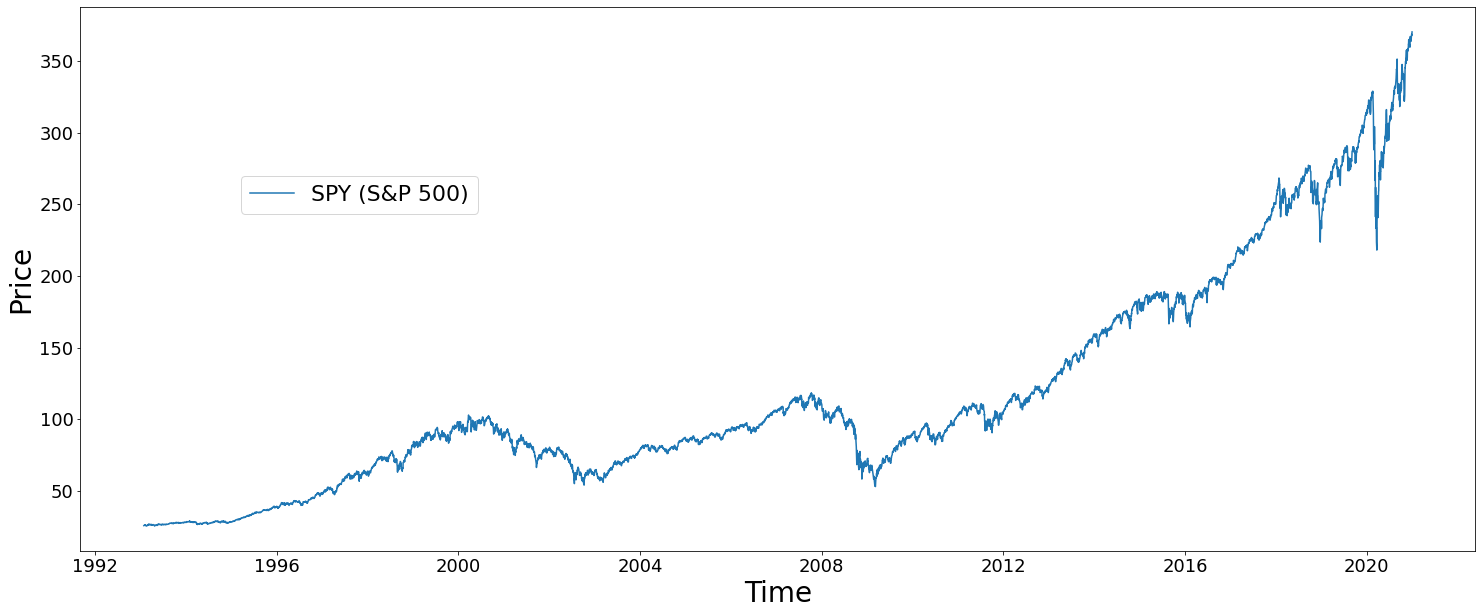

In [61]:
plt.figure(figsize=(25,10))

plt.plot(data['Close'], label='SPY (S&P 500)')

plt.legend(loc='lower center', bbox_to_anchor=(0.2, 0.6), fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Time', fontsize=28)
plt.ylabel('Price', fontsize=28)

plt.show()

In [62]:
macd = ta.utils.dropna(data)
macd = ta.add_all_ta_features(macd, "Open", "High", "Low", "Close", "Volume", fillna=True)
macd = macd[["Open", "High", "Low", "Close", "Volume", 'trend_macd_diff', 'trend_macd', 'trend_macd_signal']]

/Users/qingweilan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/Users/qingweilan/.pyenv/versions/3.8.12/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


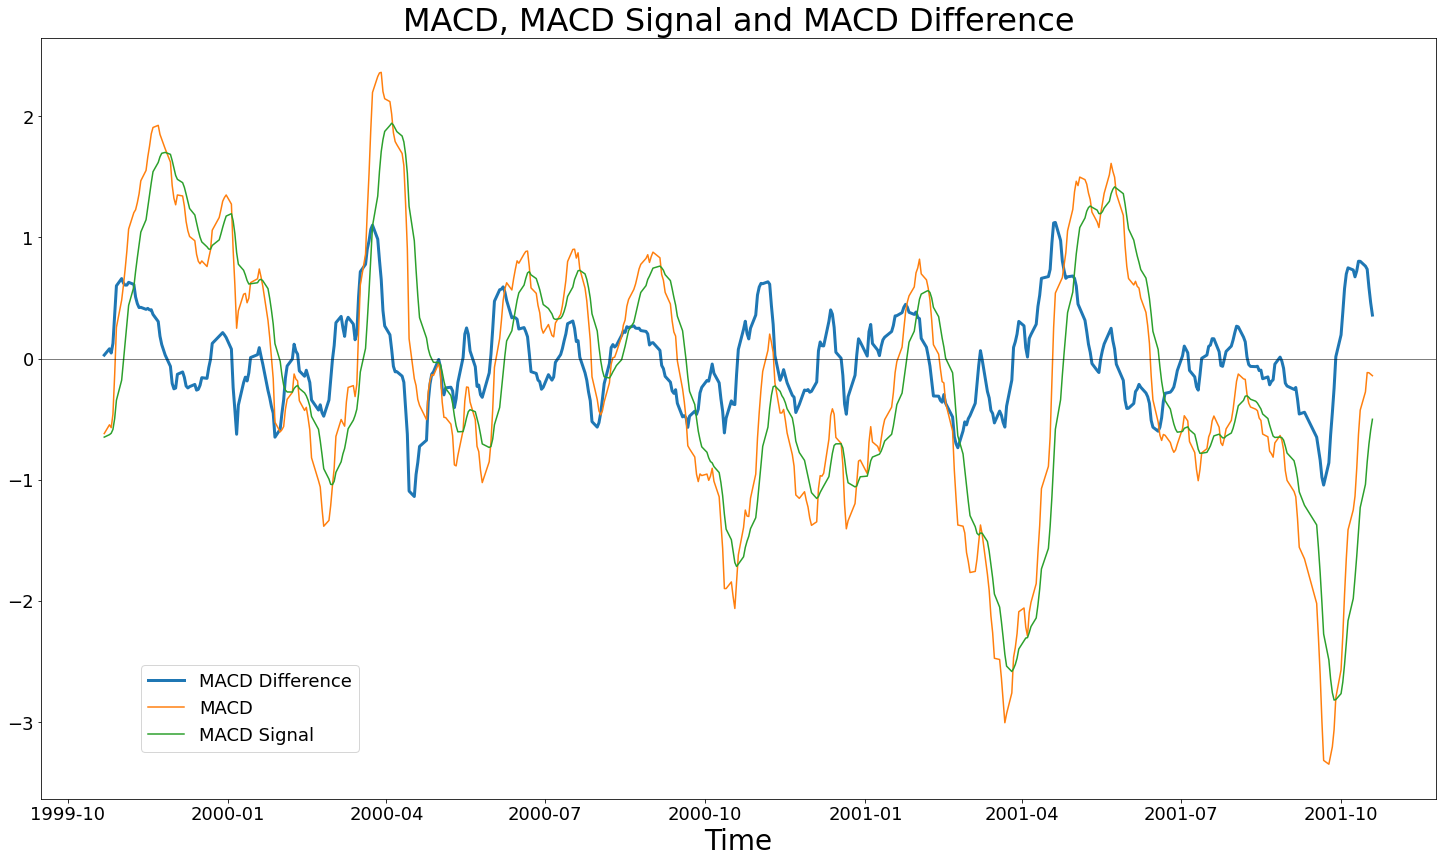

In [63]:
start, end = 1700, 2200

plt.figure(figsize=(25,14))

plt.plot(df[start:end]['trend_macd_diff'], label='MACD Difference', linewidth=3)
plt.plot(df[start:end]['trend_macd'], label='MACD')
plt.plot(df[start:end]['trend_macd_signal'], label='MACD Signal')

plt.legend(loc='lower center', bbox_to_anchor=(0.15, 0.05), fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Time', fontsize=28)

plt.axhline(0, color='black', linewidth=0.5)

plt.title('MACD, MACD Signal and MACD Difference', fontsize=32)

plt.show()

In [64]:
def macd_cross(row):
    if row['trend_macd_diff_shifted'] > 0 and row['trend_macd_diff'] < 0:
        return 'B'
    if row['trend_macd_diff_shifted'] < 0 and row['trend_macd_diff'] > 0:
        return 'S'
    return 'H'

In [65]:
macd['trend_macd_diff_shifted'] = macd['trend_macd_diff'].shift(-1)
macd['cross'] = macd.apply(lambda row: macd_cross(row), axis=1)
macd['action'] = macd['cross'].shift(1)
macd_used = macd[-1402:-1][["Open", "High", "Low", "Close", "Volume", "action"]]
macd_used

/var/folders/cc/2hgv16qj2r95km6wqkh0r0z80000gn/T/ipykernel_50442/3038545573.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  macd['trend_macd_diff_shifted'] = macd['trend_macd_diff'].shift(-1)
/var/folders/cc/2hgv16qj2r95km6wqkh0r0z80000gn/T/ipykernel_50442/3038545573.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  macd['cross'] = macd.apply(lambda row: macd_cross(row), axis=1)
/var/folders/cc/2hgv16qj2r95km6wqkh0r0z80000gn/T/ipykernel_50442/3038545573.py:3: SettingWithCopyWarning: 
A value is trying

,Open,High,Low,Close,Volume,action
Date,,,,,,
2015-06-10,185.270565,187.075759,185.208629,186.668701,134551300,H
2015-06-11,187.137689,187.677476,186.889919,187.270432,73876400,H
2015-06-12,186.394387,187.137696,185.544882,185.836899,135382400,H
2015-06-15,184.624580,185.341343,183.872413,185.040482,124384200,H
2015-06-16,184.881202,186.137766,184.695382,186.049271,85308200,H
...,...,...,...,...,...,...
2020-12-23,364.712299,366.039314,363.662570,364.009186,46201400,H
2020-12-24,364.514223,365.455032,363.890351,365.425323,26457900,H
2020-12-28,368.138779,368.980551,367.475286,368.564636,39000400,H


In [66]:
macd_perf = evaluation.eval(macd_used)

Performance: 176.58%


In [67]:
bh = data.copy(deep=True)
bh['action'] = bh.apply(lambda _: 'H', axis=1)
bh = bh[-1402:-1]
bh.loc[bh.index[0], 'action'] = 'B'
bh

,Open,High,Low,Close,Volume,action
Date,,,,,,
2015-06-10,185.270550,187.075744,185.208614,186.668686,134551300,B
2015-06-11,187.137704,187.677491,186.889935,187.270447,73876400,H
2015-06-12,186.394387,187.137696,185.544882,185.836899,135382400,H
2015-06-15,184.624580,185.341343,183.872413,185.040482,124384200,H
2015-06-16,184.881217,186.137781,184.695397,186.049286,85308200,H
...,...,...,...,...,...,...
2020-12-23,364.712299,366.039314,363.662570,364.009186,46201400,H
2020-12-24,364.514223,365.455032,363.890351,365.425323,26457900,H
2020-12-28,368.138779,368.980551,367.475286,368.564636,39000400,H


In [69]:
bh_perf = evaluation.eval(bh)

Performance: 98.84%


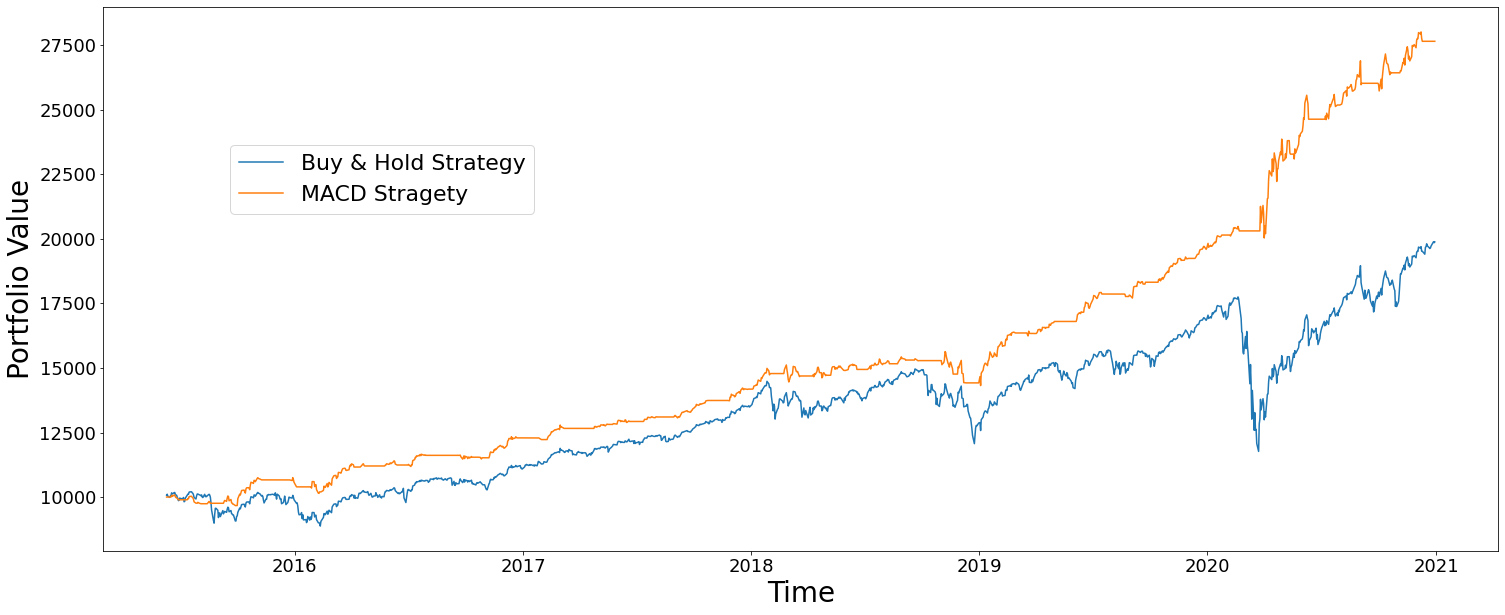

In [70]:
plt.figure(figsize=(25,10))

plt.plot(bh_perf['value'], label='Buy & Hold Strategy')
plt.plot(macd_perf['value'], label='MACD Stragety')

plt.legend(loc='lower center', bbox_to_anchor=(0.2, 0.6), fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Time', fontsize=28)
plt.ylabel('Portfolio Value', fontsize=28)

plt.show()

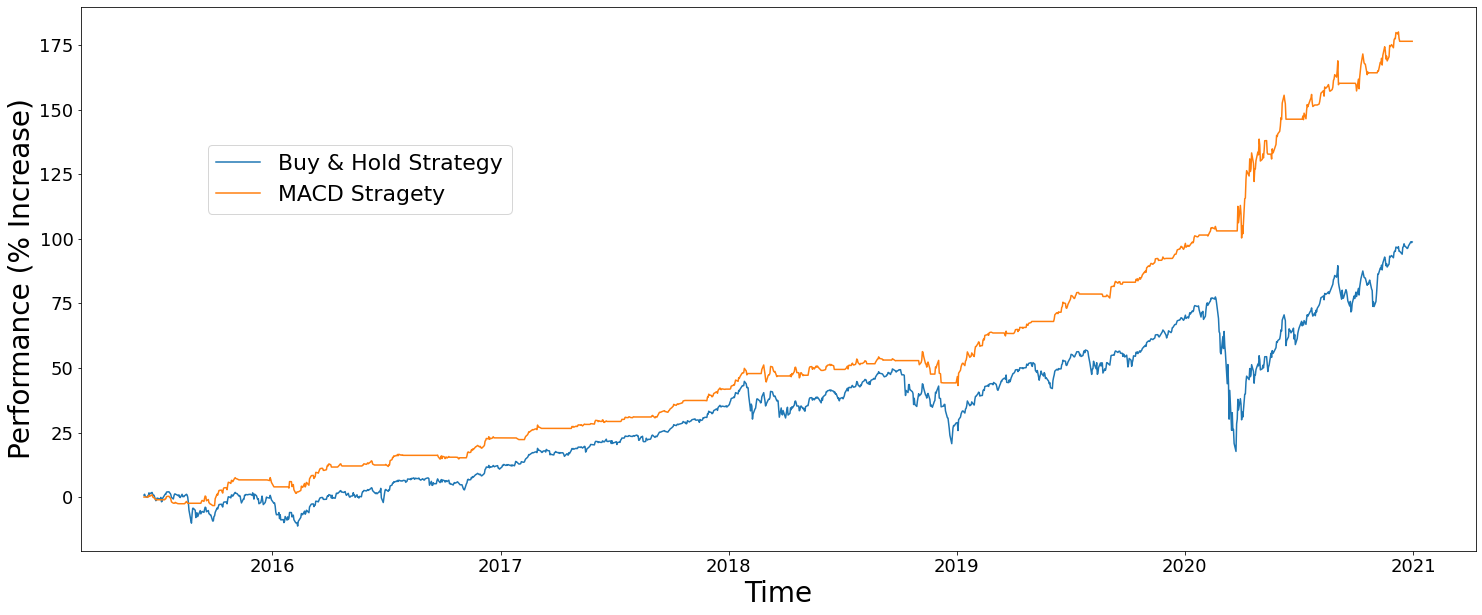

In [71]:
plt.figure(figsize=(25,10))

plt.plot(bh_perf['percentage'], label='Buy & Hold Strategy')
plt.plot(macd_perf['percentage'], label='MACD Stragety')

plt.legend(loc='lower center', bbox_to_anchor=(0.2, 0.6), fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Time', fontsize=28)
plt.ylabel('Performance (% Increase)', fontsize=28)

plt.show()